WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode finished after 99 time steps


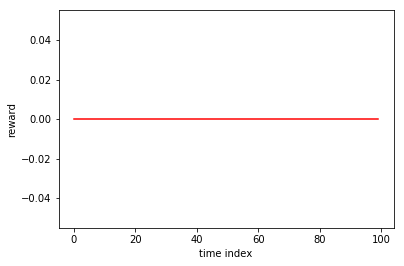

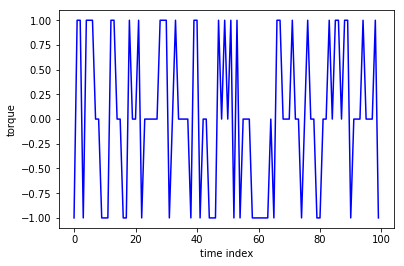

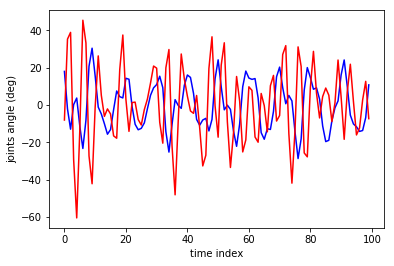

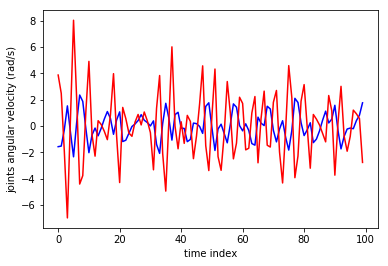

In [3]:

"""
Acrobot Environment
"""

from gym import core, spaces
from gym.utils import seeding
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt


class AcrobotEnv(core.Env):

    dt = 0.2
    # model parameters
    m1 = 2
    m2 = 2
    l1 = 0.75
    l2 = 0.75
    I1 = 0.0938
    I2 = 0.0938

    delta = np.pi / 4
    q1_min = np.pi / 2 - delta
    q1_max = np.pi / 2 + delta

    q2_min = 0 - delta
    q2_max = 0 + delta

    dq1_max = 4 * np.pi
    dq2_max = 9 * np.pi

    torque_options = [-1.0, 0.0, +1.0]
    action_num = 3

    def __init__(self):
        state_upper_bound = np.array([pi, pi, self.dq1_max, self.dq2_max])
        state_lower_bound = -state_upper_bound
        self.state_space = spaces.Box(low=state_lower_bound, high=state_upper_bound)
        self.action_space = spaces.Discrete(self.action_num)
        self.state = None
        self.seed()
        self.viewer = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.state = self.np_random.uniform(low=-0.7, high=0.7, size=(4,))
        s = self.state
        return np.array([s[0], s[1], s[2], s[3]])

    def step(self, a):
        old_state = self.state
        applied_torque = self.torque_options[a]
        augmented_state = np.append(old_state, applied_torque)
        new_state = rk4(self.state_dot, augmented_state, [0, self.dt])
        new_state = new_state[-1]
        new_state = new_state[:4]

        if new_state[0] > 2 * pi:
            new_state[0] = new_state[0] - 2 * pi
        if new_state[0] < -2 * pi:
            new_state[0] = new_state[0] + 2 * pi

        if new_state[1] > 2 * pi:
            new_state[1] = new_state[1] - 2 * pi
        if new_state[1] < -2 * pi:
            new_state[1] = new_state[1] + 2 * pi

        self.state = new_state
        if self.q1_min < new_state[0] < self.q1_max and self.q2_min < new_state[1] < self.q2_max:
            immediate_reward = +1
        else:
            immediate_reward = 0

        observations = np.array([new_state[0], new_state[1], new_state[2], new_state[3]])
        return observations, immediate_reward, {}

    def state_dot(self, s_augmented, t):
        m1 = self.m1
        m2 = self.m2
        l1 = self.l1
        lc1 = l1/2
        lc2 = l1/2
        I1 = self.I1
        I2 = self.I2
        g = 9.8
        a = s_augmented[-1]
        s = s_augmented[:-1]
        q1 = s[0]
        q2 = s[1]
        dq1 = s[2]
        dq2 = s[3]
        d1 = m1 * lc1 ** 2 + m2 * \
            (l1 ** 2 + lc2 ** 2 + 2 * l1 * lc2 * np.cos(q2)) + I1 + I2
        d2 = m2 * (lc2 ** 2 + l1 * lc2 * np.cos(q2)) + I2
        phi2 = m2 * lc2 * g * np.cos(q1 + q2 - np.pi / 2.)
        phi1 = - m2 * l1 * lc2 * dq2 ** 2 * np.sin(q2) \
               - 2 * m2 * l1 * lc2 * dq2 * dq1 * np.sin(q2)  \
            + (m1 * lc1 + m2 * l1) * g * np.cos(q1 - np.pi / 2) + phi2

        ddq2 = (a + d2 / d1 * phi1 - m2 * l1 * lc2 * dq1 ** 2 * np.sin(q2) - phi2) \
                / (m2 * lc2 ** 2 + I2 - d2 ** 2 / d1)
        ddq1 = -(d2 * ddq2 + phi1) / d1
        return dq1, dq2, ddq1, ddq2, 0.

    def render(self, mode='human'):
        from gym.envs.classic_control import rendering
        s = self.state
        if self.viewer is None:
            self.viewer = rendering.Viewer(500, 500)
            self.viewer.set_bounds(-2.0, 2.0, -2.0, 2.0)

        if s is None:
            return None

        p1 = [-self.l1 * np.cos(s[0]), self.l1 * np.sin(s[0])]
        p2 = [p1[0] - self.l2 * np.cos(s[0] + s[1]), p1[1] + self.l2 * np.sin(s[0] + s[1])]

        xys = np.array([[0, 0], p1, p2])[:, ::-1]
        thetas = [s[0]-np.pi/2, s[0]+s[1]-np.pi/2]

        for ((x, y), th) in zip(xys, thetas):
            l, r, t, b = 0, self.l1, .1, -.1
            trans = rendering.Transform(rotation=th, translation=(x, y))
            link = self.viewer.draw_polygon([(l, b), (l, t), (r, t), (r, b)])
            link.add_attr(trans)
            link.set_color(1.0, 0.5, 0.5)
            joint = self.viewer.draw_circle(.1)
            joint.set_color(0.5, 0.5, 1.0)
            joint.add_attr(trans)

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()


def rk4(derivative, y0, k, *args, **kwargs):

    try:
        y_size = len(y0)
    except TypeError:
        y = np.zeros((len(k),), np.float_)
    else:
        y = np.zeros((len(k), y_size), np.float_)

    y[0] = y0
    for i in np.arange(len(k) - 1):
        current_k = k[i]
        dt = k[i + 1] - current_k
        dt2 = dt / 2.0
        y0 = y[i]
        dy1 = np.asarray(derivative(y0, current_k, *args, **kwargs))
        dy2 = np.asarray(derivative(y0 + dt2 * dy1, current_k + dt2, *args, **kwargs))
        dy3 = np.asarray(derivative(y0 + dt2 * dy2, current_k + dt2, *args, **kwargs))
        dy4 = np.asarray(derivative(y0 + dt * dy3, current_k + dt, *args, **kwargs))
        y[i + 1] = y0 + dt / 6.0 * (dy1 + 2 * dy2 + 2 * dy3 + dy4)

    return y


env = AcrobotEnv()
iteration_num = 1
index = 100
torque_options = [-1.0, 0.0, +1.0]
for i_episode in range(iteration_num):
    observation = env.reset()
    reward_vector = np.zeros(index)
    theta1 = np.zeros(index)
    theta2 = np.zeros(index)
    theta1_dot = np.zeros(index)
    theta2_dot = np.zeros(index)
    action_vector = np.zeros(index)
    T = np.zeros(index)
    for t in range(index):
        env.render()
        action = env.action_space.sample()
        torque = torque_options[action]
        observation, reward, info = env.step(action)
        reward_vector[t] = reward
        action_vector[t] = torque
        theta1[t] = (180/pi) * observation[0]
        theta2[t] = (180/pi) * observation[1]
        theta1_dot[t] = observation[2]
        theta2_dot[t] = observation[3]
        T[t] = t
        if t == index - 1:
            env.close()
            print("Episode finished after", t, "time steps")


plt.plot(T, reward_vector, 'r')
plt.ylabel('reward')
plt.xlabel('time index')
plt.show()

plt.plot(T, action_vector, 'b')
plt.ylabel('torque')
plt.xlabel('time index')
plt.show()


plt.plot(T, theta1, 'b')
plt.plot(T, theta2, 'r')
plt.ylabel('joints angle (deg)')
plt.xlabel('time index')
plt.show()

plt.plot(T, theta1_dot, 'b')
plt.plot(T, theta2_dot, 'r')
plt.ylabel('joints angular velocity (rad/s)')
plt.xlabel('time index')
plt.show()
